In [1]:
import os
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"

from typing import List, Union

from pyspark import SparkConf
import pyspark.sql.functions as F
from pyspark.context import SparkContext
from pyspark.sql import DataFrame as SparkDataFrame

import pyspark as ps
from pyspark import StorageLevel
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import mean, max, col, min, stddev, countDistinct, datediff,when,trim, upper

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.window import Window
from pyspark.sql.types import *
from collections import namedtuple

import datetime
import pandas as pd
from pandas import DataFrame
import sys
import os
import getpass
import urllib.parse
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy.stats import friedmanchisquare,kruskal,wilcoxon,ks_2samp,chi2

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder,MultiLabelBinarizer,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer,precision_recall_curve,auc,\
                roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,KFold,train_test_split,cross_validate, \
            GridSearchCV, learning_curve, validation_curve
from sklearn.utils import resample

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.iolib.smpickle import load_pickle
from statistics import stdev
import math

import pickle

import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier

import time
import datetime
from dateutil.relativedelta import relativedelta
import itertools, logging, yaml, os, sys, subprocess, time
import numpy as np
from pkg_resources import resource_filename
import pyarrow as pa

/apps/pyfarm/conda_envs/envs/pyfarmbase/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Read Data

In [2]:
dataset = pd.read_excel("MDS_Housing_Dataset.xlsx")
# Printing first 5 records of the dataset
print(dataset.head(5))

        ID                 ADDRESS       CITY STATE    ZIP  ListPrice  BEDS  \
0  4416206   1000 Larpenteur Ave W   St. Paul    MN  55113     214000     3   
1  4423768        1004 Charles Ave   St. Paul    MN  55104     134900     3   
2  4427963          1004 Euclid St   St. Paul    MN  55106     129722     4   
3  4432178  1005 Saint Anthony Ave   St. Paul    MN  55104     134900     2   
4  4440070      100X Chatsworth Pl  Shoreview    MN  55126     444900     4   

   BATHS                LOCATION  SQFT    ...      YearBuilt  ParkingSpots  \
0   2.00                    Como  1954    ...           1918             2   
1   1.00  Thomas-Dale (Frogtown)  1028    ...           1911             1   
2   1.00          Dayton's Bluff  1420    ...           1900             0   
3   1.75       Summit-University   904    ...           1928             3   
4   2.50               Shoreview  2014    ...           2014             3   

   HasGarage  DOM  SoldPrev                     Realty  

In [3]:
dataset.shape

(1111, 21)

# Exploratory Data Analysis

/apps/pyfarm/conda_envs/envs/pyfarmbase/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


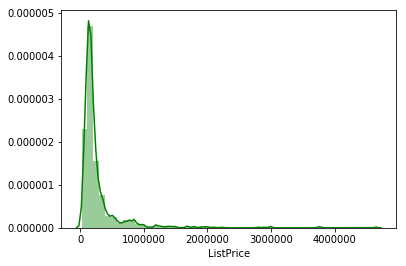

In [4]:
sns.distplot(dataset['ListPrice'], color='green')
plt.show()

In [5]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))
 
int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))
 
fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 9
Integer variables: 8
Float variables: 4


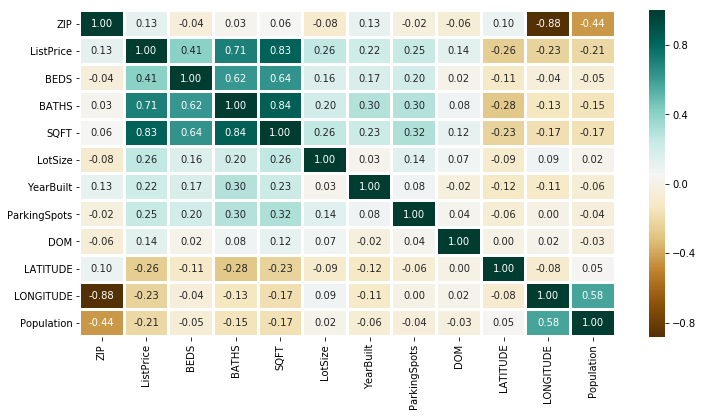

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

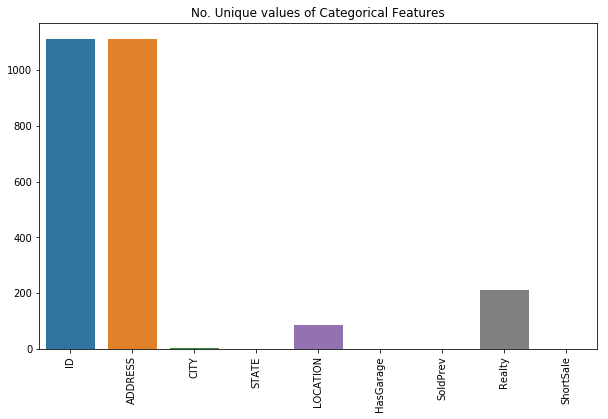

In [7]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

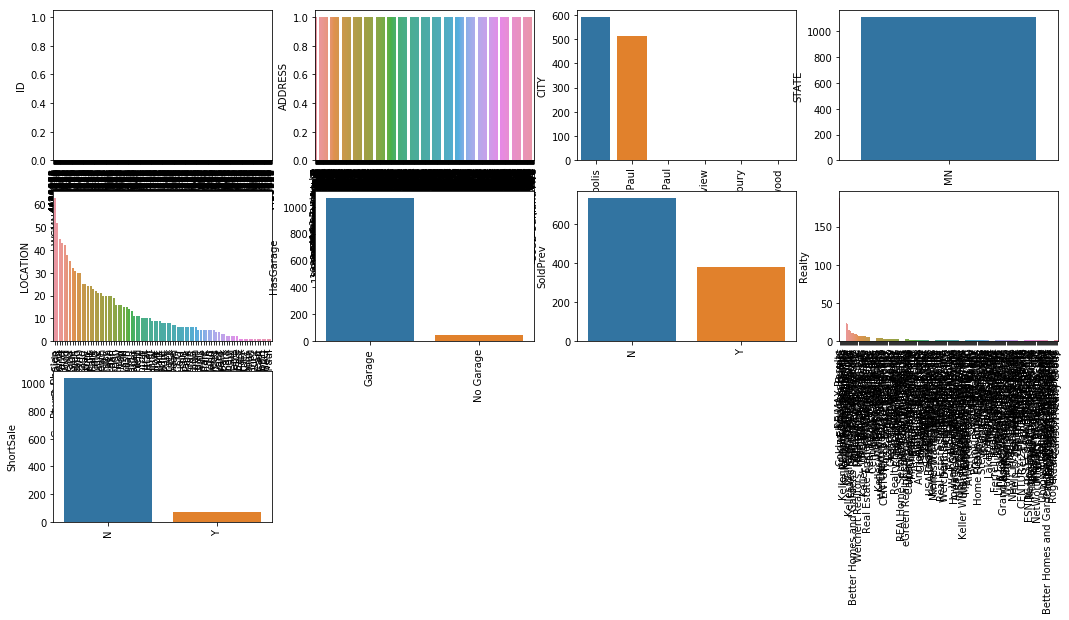

In [8]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1
 
for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

# Data Cleaning

In [9]:
dataset.drop(['ID', 'ADDRESS', 'CITY', 'STATE', 'LOCATION','Realty'],
             axis=1,
             inplace=True)

In [10]:
dataset['ListPrice'] = dataset['ListPrice'].fillna(
  dataset['ListPrice'].mean())

In [11]:
new_dataset = dataset.dropna()

In [12]:
new_dataset.isnull().sum()

ZIP             0
ListPrice       0
BEDS            0
BATHS           0
SQFT            0
LotSize         0
YearBuilt       0
ParkingSpots    0
HasGarage       0
DOM             0
SoldPrev        0
LATITUDE        0
LONGITUDE       0
ShortSale       0
Population      0
dtype: int64

In [13]:
s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ', 
      len(object_cols))

Categorical variables:
['HasGarage', 'SoldPrev', 'ShortSale']
No. of. categorical features:  3


In [14]:
df=pd.get_dummies(new_dataset)

In [15]:
df['BuildingAge']=2023-df['YearBuilt']
df.shape

(1040, 19)

In [16]:
df.drop(['YearBuilt', 'LATITUDE', 'LONGITUDE','ZIP'],
       axis=1,
       inplace=True)

In [17]:
print(df.head(5))

   ListPrice  BEDS  BATHS  SQFT  LotSize  ParkingSpots  DOM  Population  \
0     214000     3   2.00  1954   6969.0             2  117       38994   
1     134900     3   1.00  1028   4356.0             1   93       43248   
2     129722     4   1.00  1420   5227.0             0   77       52730   
3     134900     2   1.75   904   8712.0             3   57       43248   
4     444900     4   2.50  2014  12632.0             3    8       25140   

   HasGarage_Garage  HasGarage_No Garage  SoldPrev_N  SoldPrev_Y  ShortSale_N  \
0                 1                    0           0           1            1   
1                 1                    0           0           1            1   
2                 0                    1           1           0            1   
3                 1                    0           1           0            1   
4                 1                    0           1           0            1   

   ShortSale_Y  BuildingAge  
0            0          105  
1 

# Splitting Dataset into Training and Testing

In [18]:
X = df.drop(['ListPrice'], axis=1)
y = df['ListPrice']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=42)

X_train.head(5)
y_train.head(5)

1055     44900
992     414900
906     255000
125     149900
763     159900
Name: ListPrice, dtype: int64

# Feature Selection

In [19]:
def plot_feature_importance(path,importance,names,n_features,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #save to csv
    fi_df.to_csv(path + model_type + "_feat_importance.csv")
    
    #filter top 20 features to display
    top_features_df = fi_df.nlargest(n_features,['feature_importance'])
    lst_top_feat = top_features_df['feature_names'].values.tolist()

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=top_features_df['feature_importance'], y=top_features_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return lst_top_feat

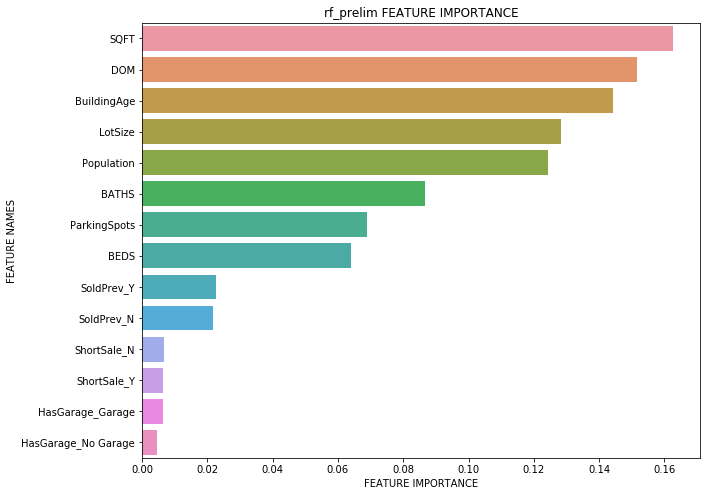

In [20]:
path = '/home/u588277/assignment_sds/'
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,y_train)

feat_labels = X_train.columns
lst_top_feat = plot_feature_importance(path=path,
                                       importance=clf.feature_importances_,
                                       names=feat_labels,
                                       n_features=20,
                                       model_type='rf_prelim')

In [21]:
top_feat = pd.read_csv(path + "rf_prelim_feat_importance.csv")
top_feat['sel'] = np.where(top_feat['feature_importance']>=0.01,1,0) 

# select top features that contribute at least 0.01
top_sel = top_feat[top_feat['sel']==1]
print("number of selected features:", len(top_sel))
print(top_sel)

number of selected features: 10
   Unnamed: 0 feature_names  feature_importance  sel
0           2          SQFT            0.162724    1
1           5           DOM            0.151733    1
2          13   BuildingAge            0.144133    1
3           3       LotSize            0.128349    1
4           6    Population            0.124445    1
5           1         BATHS            0.086770    1
6           4  ParkingSpots            0.068800    1
7           0          BEDS            0.064160    1
8          10    SoldPrev_Y            0.022615    1
9           9    SoldPrev_N            0.021901    1


In [22]:
X_train2 = X_train[top_sel.feature_names.values]
X_test2 = X_test[top_sel.feature_names.values]

print("train:", X_train2.shape)
print("test:", X_test2.shape)

X_train2.head()

train: (728, 10)
test: (312, 10)


,SQFT,DOM,BuildingAge,LotSize,Population,BATHS,ParkingSpots,BEDS,SoldPrev_Y,SoldPrev_N
1055,826,70,135,7405.0,41649,1.00,3,2,0,1
992,3155,57,25,5662.0,23851,2.50,2,3,0,1
906,2120,57,48,7405.0,18207,1.75,2,5,0,1
125,1800,106,120,4791.0,43248,1.50,2,3,0,1
763,2000,77,74,6534.0,22148,1.75,2,4,0,1


In [23]:
print(X_train2.describe())

              SQFT         DOM  BuildingAge        LotSize    Population  \
count   728.000000  728.000000   728.000000     728.000000    728.000000   
mean   1767.857143   67.385989    89.269231    6920.491758  30859.377747   
std     918.106525   47.151495    31.565509    8626.367595  11610.734168   
min     548.000000    1.000000     9.000000    1001.000000   5592.000000   
25%    1220.000000   19.000000    72.000000    4791.000000  22148.000000   
50%    1543.500000   69.000000    98.000000    5227.000000  28455.000000   
75%    1968.500000  111.000000   111.000000    6534.000000  38966.000000   
max    6783.000000  138.000000   154.000000  136778.000000  52730.000000   

            BATHS  ParkingSpots        BEDS  SoldPrev_Y  SoldPrev_N  
count  728.000000    728.000000  728.000000  728.000000  728.000000  
mean     1.708104      1.894231    3.192308    0.336538    0.663462  
std      0.783335      1.024363    0.950694    0.472850    0.472850  
min      0.750000      0.000000    

# Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
 
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train2, y_train)
y_pred = model_RFR.predict(X_test2)

print("Training Accuracy = ", model_RFR.score(X_train2, y_train))
print("Test Accuracy     = ", model_RFR.score(X_test2, y_test))

Training Accuracy =  0.9404703023459309
Test Accuracy     =  0.6448131580362164


# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(min_samples_split=2)
dt.fit(X_train2, y_train)
y_pred = dt.predict(X_test2)

print("Training Accuracy = ", dt.score(X_train2, y_train))
print("Test Accuracy     = ", dt.score(X_test2, y_test))

Training Accuracy =  1.0
Test Accuracy     =  0.5938978503855938


# Polynomial Features

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

# Define the pipeline and train model
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('rf', RandomForestRegressor(n_estimators = 1000, max_depth=5, random_state = 12))])
poly_model.fit(X_train2, y_train)

# Calculate the Score
print("Training Accuracy = ", poly_model.score(X_train2, y_train))
print("Test Accuracy     = ", poly_model.score(X_test2, y_test))

Training Accuracy =  0.926543200601233
Test Accuracy     =  0.7233694651726856


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

# Define the pipeline and train model
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])
poly_model.fit(X_train2, y_train)

# Calculate the Score
print("Training Accuracy = ", poly_model.score(X_train2, y_train))
print("Test Accuracy     = ", poly_model.score(X_test2, y_test))

Training Accuracy =  0.8296913167858774
Test Accuracy     =  0.8391089646171794


# Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train2, y_train)
y_pred = reg.predict(X_test2)

print("Training Accuracy = ", reg.score(X_train2, y_train))
print("Test Accuracy     = ", reg.score(X_test2, y_test))

Training Accuracy =  0.6905891262992012
Test Accuracy     =  0.7507817588854617


In [29]:
pd.DataFrame(reg.coef_, X_train2.columns, columns=['coefficient'])

,coefficient
SQFT,318.259621
DOM,163.976534
BuildingAge,-463.694777
LotSize,2.365380
Population,-2.196863
BATHS,31108.698395
ParkingSpots,1391.346254
BEDS,-77918.246476
SoldPrev_Y,886.376750
SoldPrev_N,-886.376750


In [30]:
reg.intercept_

-22702.700062209275

# Obeservaion :
1. Random Forest and Decision Tree have overfitting problems
2. We select the final model: Polynomial Feature over Linear Regression
3. We got 83.91 % Model Accuracy

# Final Model Evaluation

In [31]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = model.score(test_features, test_labels)

    print('Average Error  = {:0.4f} degrees'.format(np.mean(errors)))
    print('Model Accuracy = {:0.4f} %'.format(accuracy))

In [32]:
evaluate(poly_model, X_train2, y_train)

Average Error  = 83661.5170 degrees
Model Accuracy = 0.8297 %


In [33]:
evaluate(poly_model, X_test2, y_test)

Average Error  = 95211.1955 degrees
Model Accuracy = 0.8391 %


In [34]:
pred = poly_model.predict(X_test2)

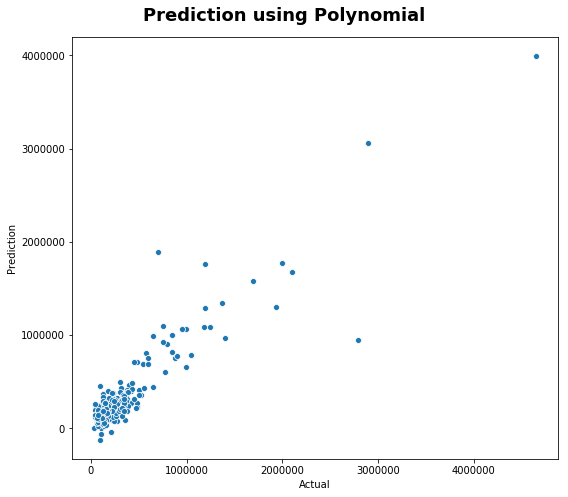

In [35]:
fig = plt.figure(figsize=(8,7))

sns.scatterplot(y_test, pred)
fig.suptitle('Prediction using Polynomial', fontsize= 18 , fontweight='bold')
plt.xlabel("Actual")
plt.ylabel("Prediction")
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

In [36]:
from pickle import dump

In [37]:
dump(poly_model,open('final_model.pkl','wb'))